# Lending Club Loan Prediction

In this notebook we will explore loan data from Lending Club between 2007 and 2019 to predict whether loan applicants will default on a loan or not.

The original data set can be found here: https://www.kaggle.com/wendykan/lending-club-loan-data

## Exploratory Data Analysis

We will begin by exploring this data set that was posted by Lending Club.

In [90]:
# Import libraries for initial data analysis

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

# Import sklearn modules
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

# Display plots in the notebook inline
%matplotlib inline

In [47]:
# Import our dataset
loans = pd.read_csv('./data/loan.csv', low_memory=False)

# View all columns
pd.set_option('display.max_columns', None)

#### Gather basic information

In [48]:
# A whopping 2.26M records with 145 features
loans.shape

(2260668, 145)

In [49]:
# Let's take a look at some of the entries
loans.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,Chef,10+ years,RENT,55000.0,Not Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,109xx,NY,18.24,0.0,Apr-2001,1.0,NaN,45.0,9.0,1.0,4341,10.3,34.0,w,2386.02,2386.02,167.02,167.02,113.98,53.04,0.0,0.0,0.0,Feb-2019,84.92,Mar-2019,Feb-2019,0.0,NaN,1,Individual,NaN,NaN,NaN,0.0,0.0,16901.0,2.0,2.0,1.0,2.0,2.0,12560.0,69.0,2.0,7.0,2137.0,28.0,42000.0,1.0,11.0,2.0,9.0,1878.0,34360.0,5.9,0.0,0.0,140.0,212.0,1.0,1.0,0.0,1.0,NaN,2.0,NaN,0.0,2.0,5.0,3.0,3.0,16.0,7.0,18.0,5.0,9.0,0.0,0.0,0.0,3.0,100.0,0.0,1.0,0.0,60124.0,16901.0,36500.0,18124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,Postmaster,10+ years,MORTGAGE,90000.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,713xx,LA,26.52,0.0,Jun-1987,0.0,71.0,75.0,13.0,1.0,12315,24.2,44.0,w,29387.75,29387.75,1507.11,1507.11,612.25,894.86,0.0,0.0,0.0,Feb-2019,777.23,Mar-2019,Feb-2019,0.0,NaN,1,Individual,NaN,NaN,NaN,0.0,1208.0,321915.0,4.0,4.0,2.0,3.0,3.0,87153.0,88.0,4.0,5.0,998.0,57.0,50800.0,2.0,15.0,2.0,10.0,24763.0,13761.0,8.3,0.0,0.0,163.0,378.0,4.0,3.0,3.0,4.0,NaN,4.0,NaN,0.0,2.0,4.0,4.0,9.0,27.0,8.0,14.0,4.0,13.0,0.0,0.0,0.0,6.0,95.0,0.0,1.0,0.0,372872.0,99468.0,15000.0,94072.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,Administrative,6 years,MORTGAGE,59280.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt cons

## Feature Engineering

The aim of this section is to create a model which can reliably predict the outcome of an issued loan based on the given features. This is a categorical model as the output will either be 1 denoting a good loan or 0 denoting a bad loan. In order to build a predictive model we will first have to do some feature engineering to prep our data set.

1.) Clean up features & records

2.) Eliminate class imbalance

3.) Deal with categorical and numeric features

### 1.) Clean up features & records

*Reduce number of features* - Out of the 145 features included with this data set, each requiring some cleanup. To prevent this from overwhelming, we'll just focus on a key set of features for now.

*Remove records prior to 2013* - Lending Club was still in growth mode between 2007-2015 (number of loans issued was doubling year over year) and their underwriting process was likely different than it is today. However we want to include loans which have reached full maturity (3 and 5 year terms) which will require us to include data as far back as 2013.

*Keep only Fully Paid and Charged off* - Remove records with loan_status other than either Fully Paid (good loan) or Charged Off (bad loan) to simplify prediction to a binary output. This will also include removing current loans since we have no way of predicting the outcome of current loan that has yet to come to term or be paid off.

*Remove joint applications* - There are a small number of loans which are joint applications. These loans should be treated differently than single applications as there are different features which will be more important when assessing each of these loan types.

*Remove redundant features* - Use correlation matrix to identify redundant features which can be dropped.

In [50]:
# Let's convert the issue_d column to actual date values that we can work with and create two new columns
loans['issue_year'] = pd.to_datetime(loans['issue_d']).dt.year
loans['issue_month'] = pd.to_datetime(loans['issue_d']).dt.month

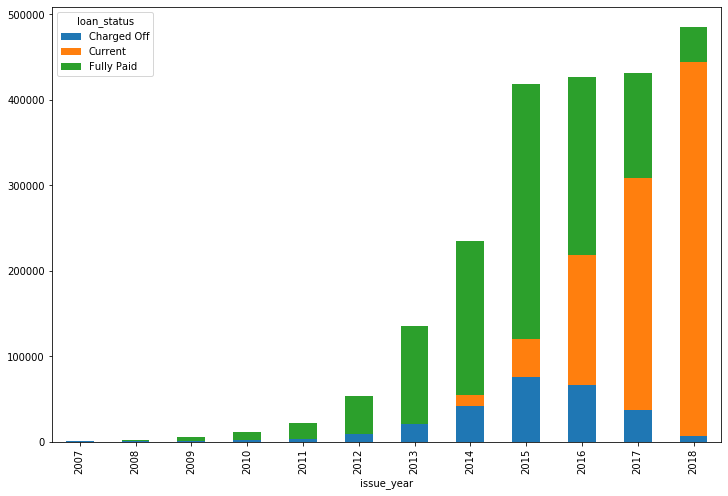

In [51]:
# Keep only records if loans status is Fully Paid, Charged Off, or Current
loans_simple = loans.loc[loans.loan_status.isin(['Fully Paid', 'Charged Off', 'Current'])]
loans_simple.groupby('issue_year').loan_status.value_counts().unstack().plot(kind='bar', figsize=(12,8), stacked=True);

In [52]:
####### Remove older records #######

# Remove records prior to 2013
loans = loans[loans.issue_year >= 2013]

####### Simplify loan status #######

# Keep only records if loans status is Fully Paid or Charged Off
loans = loans.loc[loans.loan_status.isin(['Fully Paid', 'Charged Off'])]

####### Remove joint loan applications #######

# Keep only records if application_type is Individual
loans = loans.loc[loans.application_type.isin(['Individual'])]

### A bit more EDA

#### Debt to Income Ratio

Debt-to-income is an important metric since it says approximately the level of debt of each individual consumer with respect to its total income.

*Finding*: Debt to Income ratio tends to be lower for applicants that successfully pay off their loan.

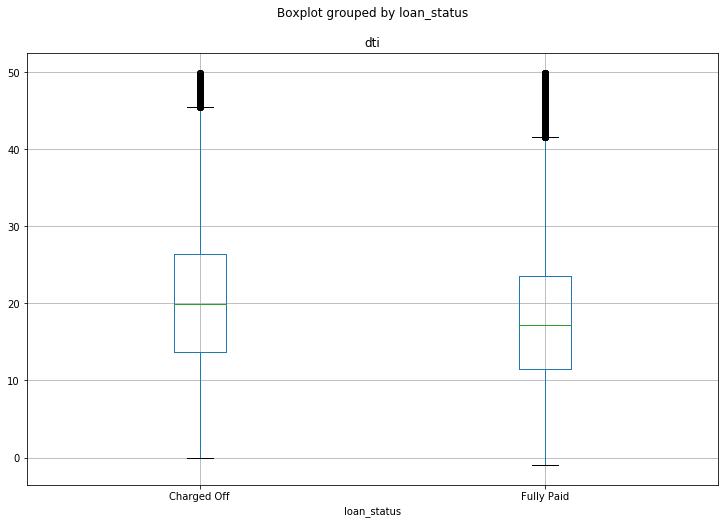

In [53]:
loans.boxplot(column='dti', by='loan_status', figsize=(12,8));

#### What Determines a Bad Loan

Factors that increase risk include: annual income, high debt to income, interest rate, loan grade, among others.

*Findings*:
- Loans of grade B and C represent the majority of loans issued, and grade C loans produce the largest number of bad loans
- Percentage-wise, loans of grade E, F, and G have nearly a 40%+ charge off rate!
- Debt consolidation is clearly the most common reason for loan applications followed by credit card (which is also debt consolidation)
- When we view by percentage we can see that default rates are roughly similar ranging from 15-30%
- Interest rate is evenly distributed by grade regardless of the total loan amount, except loans that are above 35k which tend to have lower interest rates.

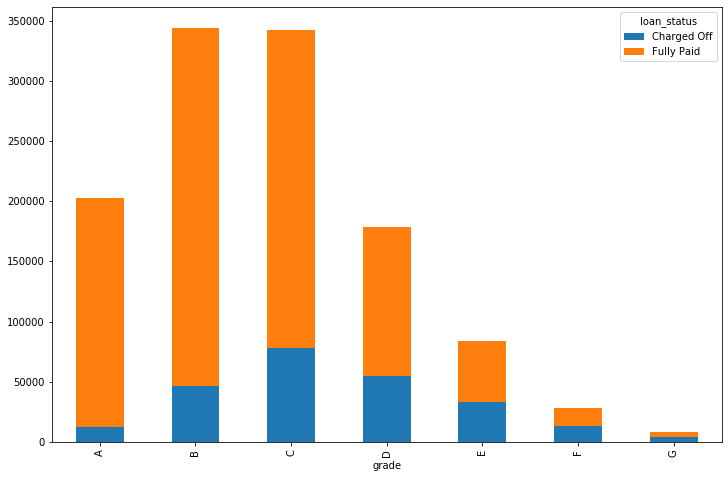

In [54]:
loans.groupby('grade')['loan_status'].value_counts().unstack().plot(kind='bar', stacked=True, figsize=(12,8));

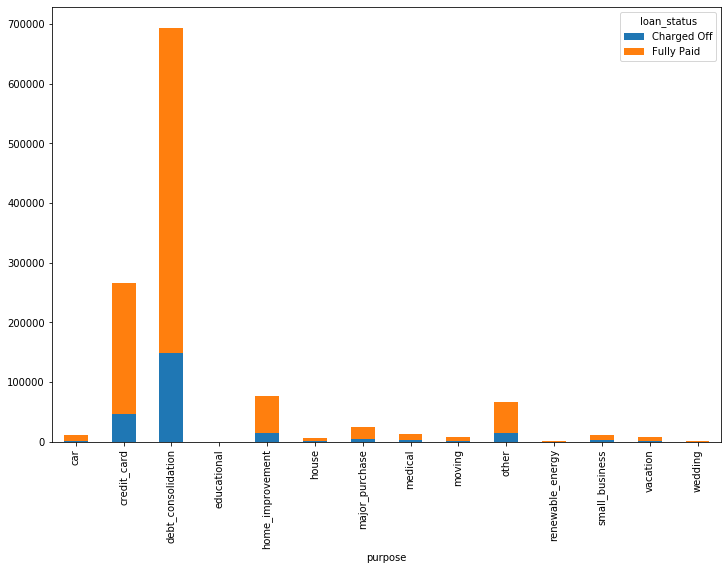

In [55]:
# Vieweing quantity of loans by purpose

loans.groupby('purpose')['loan_status'].value_counts().unstack().plot(kind='bar', stacked=True, figsize=(12,8));

purpose             loan_status
car                 Fully Paid      84.547038
                    Charged Off     15.452962
credit_card         Fully Paid      82.709153
                    Charged Off     17.290847
debt_consolidation  Fully Paid      78.502242
                    Charged Off     21.497758
educational         Fully Paid     100.000000
home_improvement    Fully Paid      81.757443
                    Charged Off     18.242557
house               Fully Paid      77.711344
                    Charged Off     22.288656
major_purchase      Fully Paid      80.214409
                    Charged Off     19.785591
medical             Fully Paid      77.794505
                    Charged Off     22.205495
moving              Fully Paid      76.069869
                    Charged Off     23.930131
other               Fully Paid      78.523057
                    Charged Off     21.476943
renewable_energy    Fully Paid      75.623269
                    Charged Off     24.376731
sm

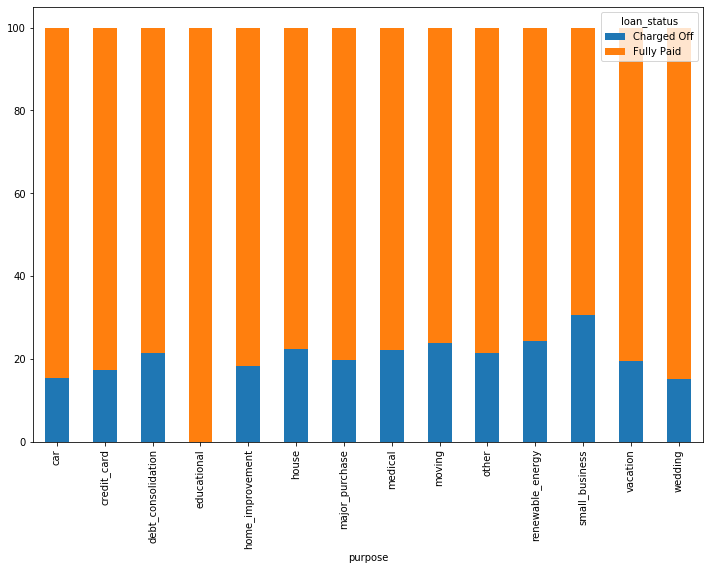

In [56]:
# Vieweing percentage of good/bad loans by purpose

perc = loans.groupby('purpose')['loan_status'].value_counts()

# Give the percentage on the level of Rank:
percbyloanstat = perc.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

print(percbyloanstat)
percbyloanstat.unstack().plot(kind='bar', stacked=True, figsize=(12,8));

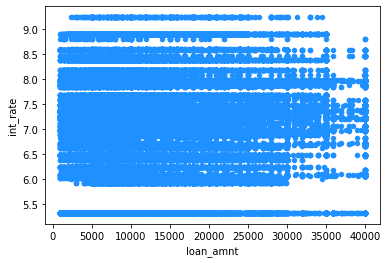

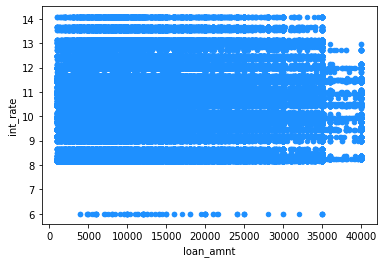

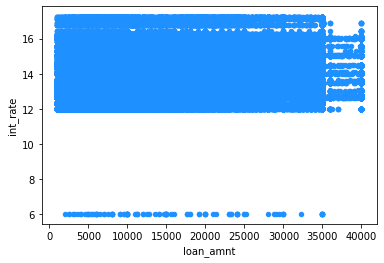

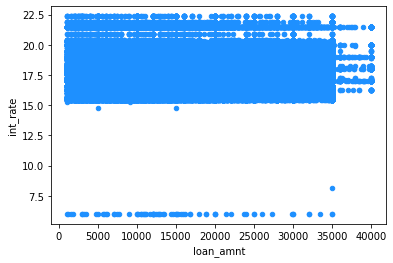

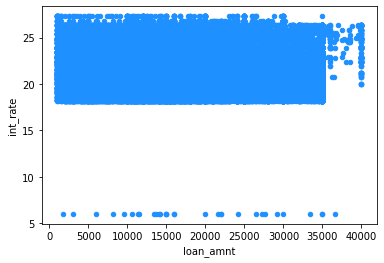

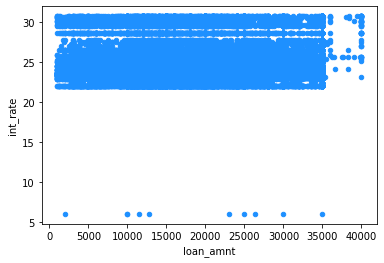

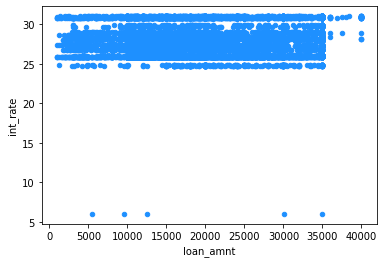

In [57]:
loans.groupby('grade').plot(x='loan_amnt', y='int_rate', kind='scatter', color='dodgerblue');

#### Back to feature engineering

In [58]:
####### Reduce number of features #######

key_features = [
    # Loan
    'loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'issue_year',
    'purpose', 'out_prncp', 'total_rec_int', 'total_pymnt',
    
    # Applicant
    'emp_length', 'home_ownership', 'annual_inc',
    
    # Basic credit history
    'open_acc', 'total_acc', 'open_rv_24m', 'inq_fi', 'acc_open_past_24mths', 'avg_cur_bal', 
    'delinq_amnt', 'mort_acc', 'num_bc_sats', 'num_bc_tl', 'num_sats', 
    
    # Bad credit history
    'collections_12_mths_ex_med', 'pub_rec', 'delinq_2yrs', 'acc_now_delinq', 'mths_since_last_major_derog', 
    'mths_since_last_delinq', 'tot_coll_amt', 'mths_since_recent_bc_dlq', 'num_tl_120dpd_2m', 'num_tl_30dpd', 
    'num_tl_90g_dpd_24m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'tax_liens', 
    
    # Fees
    'total_rec_late_fee',
    
    # Target
    'loan_status'
]

# Keep only key features
loans = loans[key_features]

loans.head()

,loan_amnt,term,int_rate,installment,grade,issue_year,purpose,out_prncp,total_rec_int,total_pymnt,emp_length,home_ownership,annual_inc,open_acc,total_acc,open_rv_24m,inq_fi,acc_open_past_24mths,avg_cur_bal,delinq_amnt,mort_acc,num_bc_sats,num_bc_tl,num_sats,collections_12_mths_ex_med,pub_rec,delinq_2yrs,acc_now_delinq,mths_since_last_major_derog,mths_since_last_delinq,tot_coll_amt,mths_since_recent_bc_dlq,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,pct_tl_nvr_dlq,percent_bc_gt_75,tax_liens,total_rec_late_fee,loan_status
186,4500,36 months,11.31,147.99,B,2018,credit_card,0.0,49.22,4549.217149,10+ years,RENT,38500.0,12.0,25.0,7.0,0.0,8.0,2428.0,0.0,0.0,5.0,6.0,12.0,0.0,0.0,0.0,0.0,25.0,25.0,306.0,NaN,0.0,0.0,0.0,91.7,0.0,0.0,0.0,Fully Paid
269,20000,60 months,17.97,507.55,D,2018,debt_consolidation,0.0,13.58,20013.577333,4 years,RENT,57000.0,10.0,16.0,3.0,0.0,3.0,3336.0,0.0,1.0,6.0,9.0,10.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,100.0,33.3,0.0,0.0,Fully Paid
271,6600,36 months,11.31,217.05,B,2018,credit_card,0.0,22.81,6622.809000,10+ years,RENT,45000.0,6.0,13.0,2.0,0.0,2.0,4473.0,0.0,0.0,4.0,4.0,6.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,84.6,50.0,0.0,0.0,Fully Paid
296,2500,36 months,13.56,84.92,C,2018,other,0.0,1.29,2501.285667,5 years,RENT,42000.0,3.0,6.0,2.0,2.0,3.0,6216.0,0.0,0.0,2.0,2.0,3.0,0.0,0.0,0.0,0.0,NaN,53.0,0.0,NaN,0.0,0.0,0.0,83.3,0.0,0.0,0.0,Fully Paid
369,4000,36 months,17.97,144.55,D,2018,house,0.0,49.92,4049.916667,5 years,MORTGAGE,60000.0,11.0,18.0,6.0,3.0,10.0,9687.0,0.0,2.0,5.0,5.0,11.0,0.0,0.0,0.0,0.0,38.0,38.0,0.0,NaN,0.0,0.0,0.0,88.2,0.0,0.0,0.0,Fully Paid


In [59]:
loans.loan_status.value_counts()

Fully Paid     945605
Charged Off    241612
Name: loan_status, dtype: int64

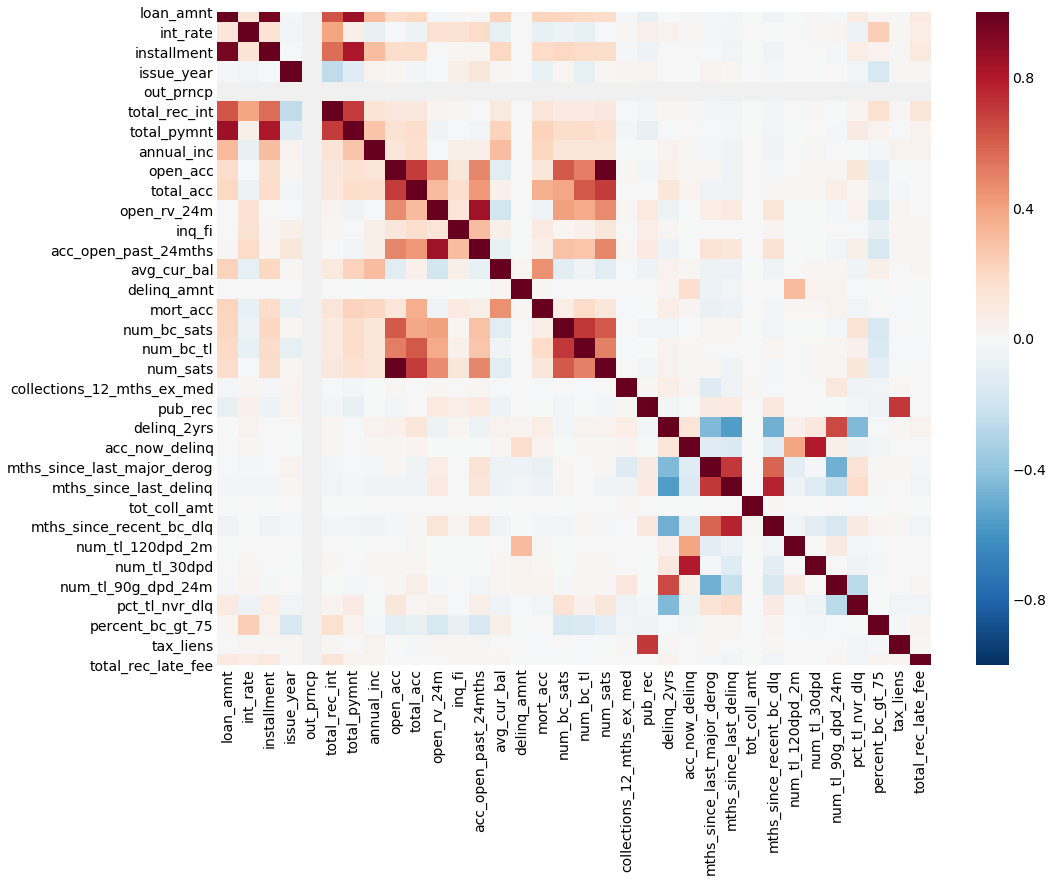

In [60]:
# Determine if any features are redundant and can be dropped.

plt.figure(figsize=(16, 12))
plt.rcParams['font.size'] = 14
plt.style.use("fivethirtyeight")

# Visualize correlation matrix
sns.heatmap(loans.corr(), cmap='RdBu_r', vmin=-1, vmax=1);

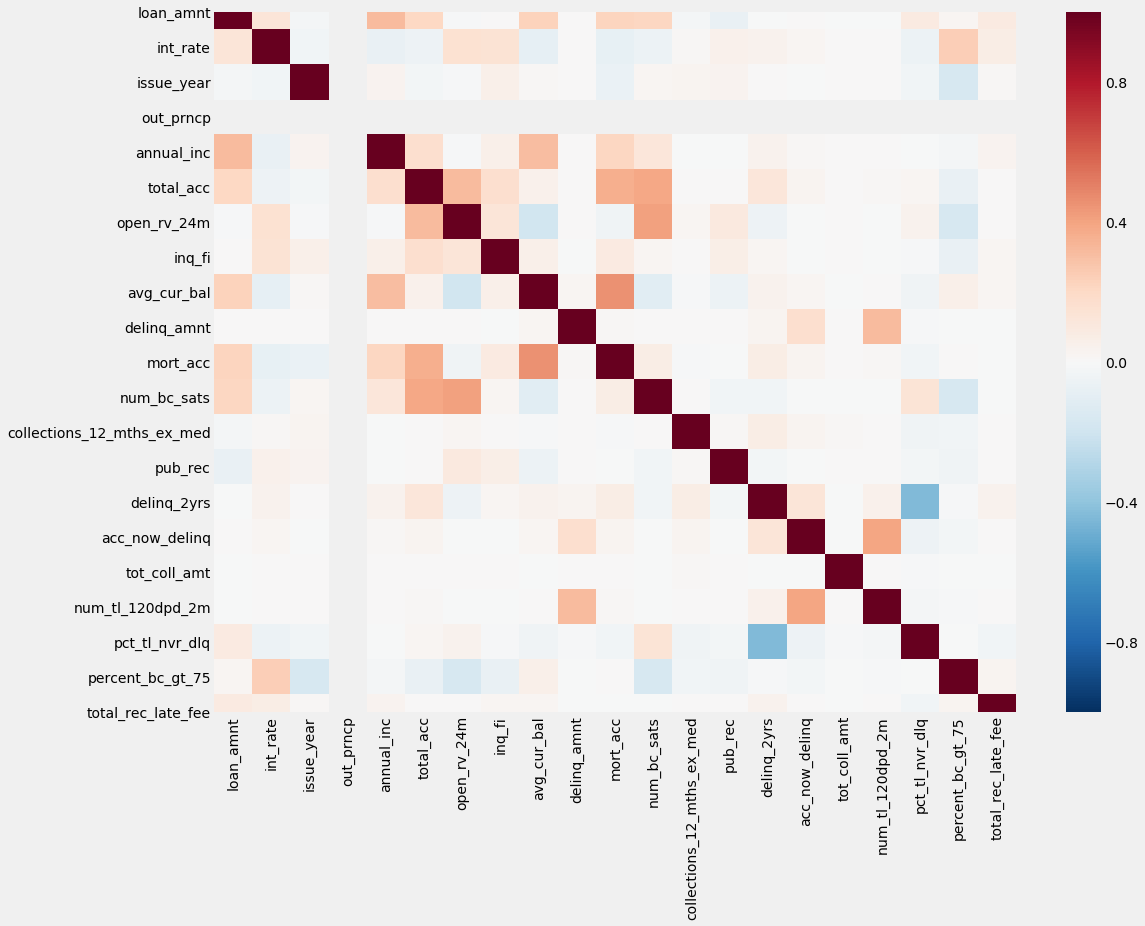

In [61]:
# We see that there are several features which have a high correlation and can be dropped.

####### Further reduce number of features #######

reduced_key_features = [
    # Loan
    'loan_amnt', 'term', 'int_rate', 'grade', 'issue_year',
    'purpose', 'out_prncp', # Remove installment, total_pymnt, total_rec_int
    
    # Applicant
    'emp_length', 'home_ownership', 'annual_inc',
    
    # Basic credit history
    'total_acc', 'open_rv_24m', 'inq_fi', 'avg_cur_bal',
    'delinq_amnt', 'mort_acc', 'num_bc_sats', # Remove open_acc, num_stats, acc_open_past_24mths, num_bc_tl
    
    # Bad credit history
    'collections_12_mths_ex_med', 'pub_rec', 'delinq_2yrs', 'acc_now_delinq', 
    'tot_coll_amt', 'num_tl_120dpd_2m', 
    'pct_tl_nvr_dlq', 'percent_bc_gt_75', # Remove tax_liens, num_tl_30dpd, mths_since_last_major_derog, mths_since_recent_bc_dlq, num_tl_90g_dpd_24m, mths_since_last_delinq
    
    # Fees
    'total_rec_late_fee',
    
    # Target
    'loan_status'
]

# Keep only key features
loans = loans[reduced_key_features]

# Visualize correlation matrix to confirm reduction of feature redundancy
plt.figure(figsize=(16, 12))
plt.rcParams['font.size'] = 14
plt.style.use("fivethirtyeight")
sns.heatmap(loans.corr(), cmap='RdBu_r', vmin=-1, vmax=1);

### 2.) Eliminate class imbalance

After examining the number of records remaining, we can see that the data set has imbalanced classes where only 20% of the records show a bad loan. Since we still have 241,612 bad loans to work with, we will down-sample our good loans to match our number of bad loans.

For future iterations of this project, we may consider using tree based algorithms which are more capable of handling imbalanced data sets.

In [62]:
# Import resampling module for sklearn
from sklearn.utils import resample

# Separate good vs bad loans
good_loans = loans[loans.loan_status == 'Fully Paid']
bad_loans = loans[loans.loan_status == 'Charged Off']
 
# Downsample good loans
good_loans_downsampled = resample(good_loans, replace=False, n_samples=241612, random_state=123)

# Recombine loans
loans = pd.concat([good_loans_downsampled, bad_loans])

In [63]:
# Confirm that are classes are now balanced
loans["loan_status"].value_counts()

Fully Paid     241612
Charged Off    241612
Name: loan_status, dtype: int64

### 3.) Deal with categorical and numeric features

### 3.1.) Deal with categorical features

There are many categorical features which will need to be encoded to numeric values before we can build our predictive model.

In [64]:
# Taking a look at the categorical features

loan_objects = loans.select_dtypes(include=['object']).copy()
loan_objects.head()

,term,grade,purpose,emp_length,home_ownership,loan_status
551023,36 months,C,debt_consolidation,10+ years,MORTGAGE,Fully Paid
1122212,60 months,C,debt_consolidation,2 years,RENT,Fully Paid
1573214,36 months,C,other,1 year,RENT,Fully Paid
703942,36 months,B,debt_consolidation,10+ years,OWN,Fully Paid
541532,36 months,B,debt_consolidation,4 years,OWN,Fully Paid


In [65]:
loan_objects[loan_objects.isnull().any(axis=1)]

,term,grade,purpose,emp_length,home_ownership,loan_status
575497,36 months,D,home_improvement,NaN,RENT,Fully Paid
1163943,36 months,D,debt_consolidation,NaN,RENT,Fully Paid
2049992,36 months,C,debt_consolidation,NaN,MORTGAGE,Fully Paid
2005570,60 months,B,debt_consolidation,NaN,OWN,Fully Paid
786125,36 months,D,debt_consolidation,NaN,RENT,Fully Paid
...,...,...,...,...,...,...
2260059,36 months,B,debt_consolidation,NaN,RENT,Charged Off
2260134,36 months,C,debt_consolidation,NaN,OWN,Charged Off
2260245,36 months,C,debt_consolidation,NaN,MORTGAGE,Charged Off
2260331,36 months,C,debt_consolidation,NaN,RENT,Charged Off


We can not only see that employment length has some empty values, but also that this feature could be converted to numeric instead of categorical values.

In [66]:
# Convert employment length feature to numeric values

def convert_employment_length(x):
    if x == '< 1 year':
        return 0.5
    if x == '1 year':
        return 1
    if x == '2 years':
        return 2
    if x == '3 years':
        return 3
    if x == '4 years':
        return 4
    if x == '5 years':
        return 5
    if x == '6 years':
        return 6
    if x == '7 years':
        return 7
    if x == '8 years':
        return 8
    if x == '9 years':
        return 9
    if x == '10+ years':
        return 10
    else:
        return 0

loans.emp_length = loans.emp_length.apply(convert_employment_length)

In [67]:
# Perform one hot encoding on remaining categorical values
loans = pd.get_dummies(loans, columns=['term', 'grade', 'purpose', 'home_ownership', 'loan_status'])

In [68]:
#loans.drop(labels='loan_status_Charged Off', axis=1)
loans = loans.drop(labels='loan_status_Charged Off', axis=1)

In [69]:
loans = loans.rename(columns={'loan_status_Fully Paid': 'loan_status'})

### 3.2.) Deal with numeric features

*Replace NaN values* - Numeric features such as mths_since_last_delinq will include a NaN value if the loan applicant does not meet that given criteria. We will want to convert these values to 0.

In [70]:
# Let's take a look at features with NaN values

loan_nums = loans.select_dtypes(exclude=['object']).copy()
loan_nums.isnull().sum().sort_values(ascending=False)

open_rv_24m                   281140
inq_fi                        281140
num_tl_120dpd_2m               22003
percent_bc_gt_75                5225
pct_tl_nvr_dlq                    60
avg_cur_bal                        9
loan_status                        0
collections_12_mths_ex_med         0
total_rec_late_fee                 0
tot_coll_amt                       0
acc_now_delinq                     0
delinq_2yrs                        0
pub_rec                            0
mort_acc                           0
num_bc_sats                        0
term_ 60 months                    0
delinq_amnt                        0
total_acc                          0
annual_inc                         0
emp_length                         0
out_prncp                          0
issue_year                         0
int_rate                           0
term_ 36 months                    0
grade_A                            0
home_ownership_RENT                0
grade_B                            0
h

In [71]:
# We will have to deal with the NaN values differently depending on the type of data point. For example,
# for mths_since_recent_bc_dlq (months since last bancard delinquency), lower values here are actually worse than
# higher values (representing more recent delinquencies). We would not want to convert NaN values to 0 because that
# would penalize loan applicants who have never had a delinquency. Instead we will convert these values to a
# high value so as to properly 'reward' users who have never had a delinquency.

# In other cases, we will simply want to convert NaN values to 0 such as in the case of inq_fi (number of personal
# finance inquiries) wherein a value of 0 would be appropriate if a user has made no inquiries.

# Each feature will have to be reviewed manually to determine an appropriate value to be replaced. In the case of 
# mths_since_recent_bc_dlq, the highest value is 202 months. For users who have never had a delinquency it seems
# appropriate to replace NaN with a value of 1000.

# 'inq_fi'   <-- Convert NaN to 0
# 'open_rv_24m'   <-- Convert NaN to 0
# 'num_tl_120dpd_2m'   <-- Convert NaN to 0
# 'percent_bc_gt_75'   <-- Convert NaN to 0
# 'pct_tl_nvr_dlq'   <-- Convert NaN to 100
# 'avg_cur_bal'   <-- Convert NaN to 0

loans = loans.fillna(value={
'inq_fi': 0,
'open_rv_24m': 0,
'num_tl_120dpd_2m': 0,
'percent_bc_gt_75': 0,
'pct_tl_nvr_dlq': 100,
'avg_cur_bal': 0
})

## Predictive Modeling

Now that we have performed feature engineering, we are ready to test a few models.

### Prep Data

#### Sample down dataset
To improve model performance, we'll sample down the dataset

In [72]:
good_loans = loans[loans.loan_status == 1]
bad_loans = loans[loans.loan_status == 0]

good_loans_downsampled = good_loans.sample(n=25000, random_state=123)
bad_loans_downsampled = bad_loans.sample(n=25000, random_state=123)

loans_downsampled = pd.concat([good_loans_downsampled, bad_loans_downsampled])

#### Separate feature matrix and response

In [73]:
# Create a full feature matrix
features = ['loan_amnt', 'int_rate', 'issue_year', 'out_prncp', 'emp_length', 'annual_inc', 'total_acc', 'open_rv_24m', 'inq_fi', 'avg_cur_bal', 'delinq_amnt', 'mort_acc', 'num_bc_sats', 'collections_12_mths_ex_med', 'pub_rec', 'delinq_2yrs', 'acc_now_delinq', 'tot_coll_amt', 'num_tl_120dpd_2m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'total_rec_late_fee', 'term_ 36 months', 'term_ 60 months', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G', 'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase', 'purpose_medical', 'purpose_moving', 'purpose_other', 'purpose_renewable_energy', 'purpose_small_business', 'purpose_vacation', 'purpose_wedding', 'home_ownership_ANY', 'home_ownership_MORTGAGE', 'home_ownership_OWN', 'home_ownership_RENT']

x = loans_downsampled[features]
y = loans_downsampled.loan_status

### Apply a Neural Network

In [74]:
# Split data into training and test groups

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=100)

In [75]:
feature_num = x.shape[1]
print(feature_num)

48


In [76]:
# Create Neural Network
model = Sequential() # Instantiate model ('Sequential' = A linear stack of layers)
model.add(Dense(64, input_dim=feature_num, activation='relu')) # 'Dense' = Fully-connected layer)
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [77]:
model.fit(x_train, y_train, epochs=15, batch_size=10)

Epoch 1/15
37500/37500 [==============================] - 7s 189us/step - loss: 77.8792 - accuracy: 0.5243 1s - 
Epoch 2/15
37500/37500 [==============================] - 7s 185us/step - loss: 25.6208 - accuracy: 0.5356
Epoch 3/15
37500/37500 [==============================] - 7s 174us/step - loss: 8.8091 - accuracy: 0.5527
Epoch 4/15
37500/37500 [==============================] - 6s 169us/step - loss: 4.4875 - accuracy: 0.5562
Epoch 5/15
37500/37500 [==============================] - 6s 172us/step - loss: 2.5432 - accuracy: 0.5526
Epoch 6/15
37500/37500 [==============================] - 6s 173us/step - loss: 1.0618 - accuracy: 0.5427
Epoch 7/15
37500/37500 [==============================] - 7s 178us/step - loss: 0.7280 - accuracy: 0.5551
Epoch 8/15
37500/37500 [==============================] - 6s 168us/step - loss: 0.7093 - accuracy: 0.5471
Epoch 9/15
37500/37500 [==============================] - 6s 161us/step - loss: 0.6909 - accuracy: 0.5397
Epoch 10/15
37500/37500 [=============

In [78]:
scores = model.evaluate(x_test, y_test)
print('Tensorflow accuracy', scores[1])

12500/12500 [==============================] - 0s 32us/step
Tensorflow accuracy 0.49880000948905945


### Apply a KNN model

In [79]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=100)

# Standardize the data using StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [80]:
# Apply KNN Model (K=1000)

knn = KNeighborsClassifier(n_neighbors=1000)
knn.fit(x_train, y_train)

y_pred_class = knn.predict(x_test)
print('KNN model accuracy', (metrics.accuracy_score(y_test, y_pred_class)))

KNN model accuracy 0.64544


### Apply a Logistic Regression Model

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=100)

In [86]:
# Apply Logistic Regression model
lr = LogisticRegression()
lr.fit(x_train,y_train)
y_pred = lr.predict(x_test)

lr.score(x_test, y_test)

/Users/justin/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.66184

### Extracting importance of features

In [91]:
model = RandomForestClassifier(n_estimators=50)
scores = cross_val_score(model, x, y, scoring='roc_auc')
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))
model.fit(x, y)

features = x.columns
feature_importances = model.feature_importances_
features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df

/Users/justin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


CV AUC [0.7234078  0.7233039  0.72453804], Average AUC 0.7237499122534862


,Features,Importance Score
1,int_rate,0.106970
9,avg_cur_bal,0.092762
5,annual_inc,0.082759
0,loan_amnt,0.077648
6,total_acc,0.075047
12,num_bc_sats,0.054086
20,percent_bc_gt_75,0.052440
19,pct_tl_nvr_dlq,0.051515
4,emp_length,0.050395
11,mort_acc,0.034523
